In [1]:
# Programa Python para criar 
# Classificador de imagens usando CNN
  
# Importando bibliotecas
import cv2 
import os 
import numpy as np 
from random import shuffle 
from tqdm import tqdm 

In [2]:
'''Configurando o env'''
  
TRAIN_DIR = 'train'
TEST_DIR = 'test'
IMG_SIZE = 50
LR = 1e-3

In [3]:
'''Configurando o modelo que ajudará com modelos de tensorflow'''
MODEL_NAME = 'soilvstree-{}-{}.model'.format(LR, '6conv-basic') 
  
'''Rotulando o conjunto de dados'''
def label_img(img): 
    word_label = img.split('.')[0]  
    if 'tree' in word_label: return [1, 0] 
    elif 'soil' in word_label: return [0, 1] 
  
'''Criando a base de treinamento'''
def create_train_data(): 
    # Criar uma lista vazia onde devemos armazenar os dados de treinamento 
    # depois de um pequeno pré-processamento dos dados
    training_data = [] 
  
    # tqdm é usado apenas para carregamento interativo
    # carregando a bse de treinamento
    for img in tqdm(os.listdir(TRAIN_DIR)): 
  
        # rotulando as imagens
        label = label_img(img) 
  
        path = os.path.join(TRAIN_DIR, img) 
  
        # carregar a imagem do caminho e depois convertê-los em 
        # escala de cinza para fácil convergência
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
  
        # redimensionar a imagem para processá-la na covnet
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
  
        # etapa final formando a lista de dados de treinamento com matriz de imagens da numpy
        training_data.append([np.array(img), np.array(label)]) 
  
    # embaralhamento dos dados de treinamento para preservar o estado aleatório de nossos dados 
    shuffle(training_data) 
  
    # salvando nossos dados treinados para usos futuros, se necessário
    np.save('train_data.npy', training_data) 
    return training_data 

In [4]:
'''Processando os dados de teste fornecidos'''
# Quase o mesmo que processar os dados de treinamento, mas 
# não temos os rotulos ainda.
def process_test_data(): 
    testing_data = [] 
    for img in tqdm(os.listdir(TEST_DIR)): 
        path = os.path.join(TEST_DIR, img) 
        img_num = img.split('.')[0] 
        img = cv2.imread(path, cv2.IMREAD_GRAYSCALE) 
        img = cv2.resize(img, (IMG_SIZE, IMG_SIZE)) 
        testing_data.append([np.array(img), img_num]) 
          
    shuffle(testing_data) 
    np.save('test_data.npy', testing_data) 
    return testing_data 
  
'''Executar o treinamento e o teste no conjunto de dados para nosso modelo'''
train_data = create_train_data() 
test_data = process_test_data() 

100%|██████████| 100/100 [00:00<00:00, 9627.47it/s]


In [5]:
# Importando bibliotecas e criando modelo 
import tflearn 
from tflearn.layers.conv import conv_2d, max_pool_2d 
from tflearn.layers.core import input_data, dropout, fully_connected 
from tflearn.layers.estimator import regression 
  
import tensorflow as tf 
convnet = input_data(shape =[None, IMG_SIZE, IMG_SIZE, 1], name ='input') 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 128, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 64, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = conv_2d(convnet, 32, 5, activation ='relu') 
convnet = max_pool_2d(convnet, 5) 
  
convnet = fully_connected(convnet, 1024, activation ='relu') 
convnet = dropout(convnet, 0.8) 
  
convnet = fully_connected(convnet, 2, activation ='softmax') 
convnet = regression(convnet, optimizer ='adam', learning_rate = LR, 
      loss ='categorical_crossentropy', name ='targets') 
  
model = tflearn.DNN(convnet, tensorboard_dir ='log') 

Instructions for updating:
non-resource variables are not supported in the long term
Scipy not supported!
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
# Dividindo os dados de teste e dados de treinamento.
# 80% para traino e 20% para teste, respeitando as boas práticas.
train = train_data[:-5258] 
test = train_data[-1314:] 
  
'''Configurando as características e rotulos'''
# X-Features e Y-Labels 
  
X = np.array([i[0] for i in train]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
Y = [i[1] for i in train] 
test_x = np.array([i[0] for i in test]).reshape(-1, IMG_SIZE, IMG_SIZE, 1) 
test_y = [i[1] for i in test] 
  
'''Fitting os dados no nosso modelo'''
model.fit({'input': X}, {'targets': Y}, n_epoch = 5,  
    validation_set =({'input': test_x}, {'targets': test_y}),  
    snapshot_step = 500, show_metric = True, run_id = MODEL_NAME) 
model.save('model.tflearn') 

Training Step: 104  | total loss: 0.30252 | time: 0.912s
| Adam | epoch: 005 | loss: 0.30252 - acc: 0.9109 -- iter: 1280/1314
Training Step: 105  | total loss: 0.29458 | time: 1.958s
| Adam | epoch: 005 | loss: 0.29458 - acc: 0.9104 | val_loss: 0.18237 - val_acc: 0.9391 -- iter: 1314/1314
--
INFO:tensorflow:/home/ronn/workspace/desafio_visaocomputacional_ronylldosilva/model.tflearn is not in all_model_checkpoint_paths. Manually adding it.


100%|██████████| 100/100 [00:00<00:00, 7695.26it/s]


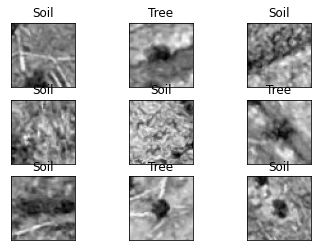

In [7]:
'''Testando com algumas imagens. Vou utilizar 9 imagens para plotar.'''
# Apenas alguns exemplos aleatórios para visualizarmos o desempenho do modelo.
# Lembrando que as imagens usadas aqui, não foram utilizadas no modelo treinado.

import matplotlib.pyplot as plt 
test_data = process_test_data() 
  
fig = plt.figure() 
  
for num, data in enumerate(test_data[:9]): 
    # tree: [1, 0] 
    # soil: [0, 1] 
      
    img_num = data[1] 
    img_data = data[0] 
      
    y = fig.add_subplot(3, 3, num + 1) 
    orig = img_data 
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1) 
  
    model_out = model.predict([data])[0] 
      
    if np.argmax(model_out) == 1: str_label = 'Soil'
    else: str_label = 'Tree'
          
    y.imshow(orig, cmap = 'gray') 
    plt.title(str_label) 
    y.axes.get_xaxis().set_visible(False) 
    y.axes.get_yaxis().set_visible(False) 
    
plt.show() 

In [8]:
# Testando com 100 imagens da pasta 'test'.
# O resultado me parece muito bom :D

accuracy = 0
for num, data in enumerate(test_data): 
    # tree: [1, 0] 
    # soil: [0, 1] 
      
    img_num = data[1] 
    img_data = data[0] 
    
    orig = img_data 
    data = img_data.reshape(IMG_SIZE, IMG_SIZE, 1) 
  
    ground_truth = -1
    if 'tree' in img_num: ground_truth = 0 
    elif 'soil' in img_num: ground_truth = 1

    model_out = model.predict([data])[0]
    
    if np.argmax(model_out) == ground_truth: accuracy += 1

result = 'Acuracia = {}%'.format(accuracy)
print(result)

Acuracia = 95%


In [2]:
# Os próximos passos seriam utilizar:

# - Arquiteturas profundas.
# - Otimização dos hiperparametros.
# - Fine Tunning e Transfer Learning.

# Também seria ótimo fazer um teste de sanidade na base de dados, 
# para encontrar e remover outliers e dados que não fazem sentido no mundo real.